**LSTM** **NEW**

<>:14: SyntaxWarning: invalid escape sequence '\.'
<>:14: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipython-input-1184094498.py:14: SyntaxWarning: invalid escape sequence '\.'
  df['Local time'] = pd.to_datetime(df['Local time'].str.split('\.').str[0], format='%d.%m.%Y %H:%M:%S', errors='coerce')


Epoch 1/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0303 - mae: 0.0964 - rmse: 0.2776 - val_loss: 2.4747e-04 - val_mae: 0.0123 - val_rmse: 0.0187
Epoch 2/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2.0498e-04 - mae: 0.0108 - rmse: 0.2594 - val_loss: 1.4762e-04 - val_mae: 0.0094 - val_rmse: 0.0167
Epoch 3/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.7075e-04 - mae: 0.0098 - rmse: 0.2624 - val_loss: 8.3043e-05 - val_mae: 0.0068 - val_rmse: 0.0149
Epoch 4/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.8591e-04 - mae: 0.0100 - rmse: 0.2651 - val_loss: 8.2640e-05 - val_mae: 0.0068 - val_rmse: 0.0149
Epoch 5/50
279/282 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7849e-04 - mae: 0.0099 - rmse: 0.2625Epoch  5 | Train MAPE: 0.49%, Val MAPE: 0.40% | Train R²: 0.9952, Val R²: 0.9910
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 1.7850e-04 - mae: 0.0099 - rmse: 0.2625 - val_loss: 8.1207e-05 - val_mae: 0.0068 - val_rmse: 0.0149
Epoch 6/50
282/282 ━━━━━━━━━━━━━━

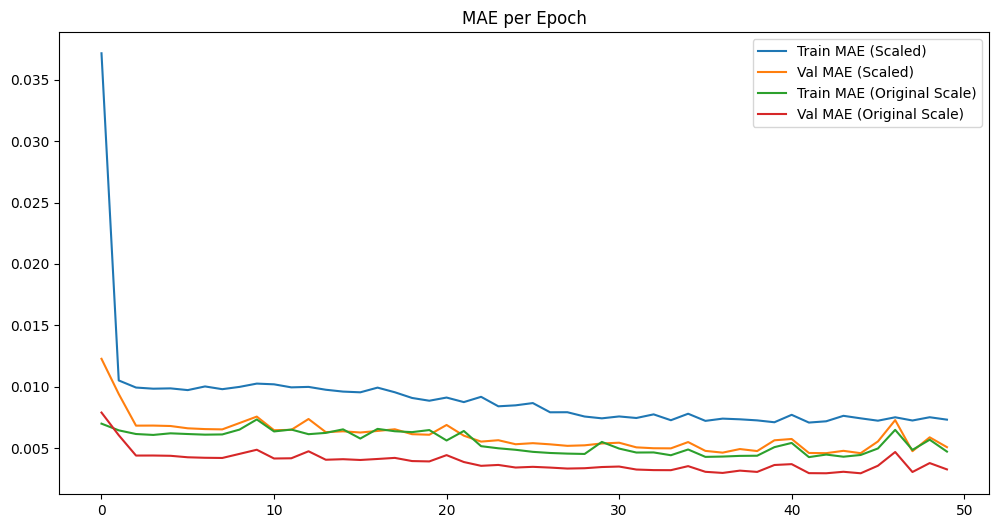

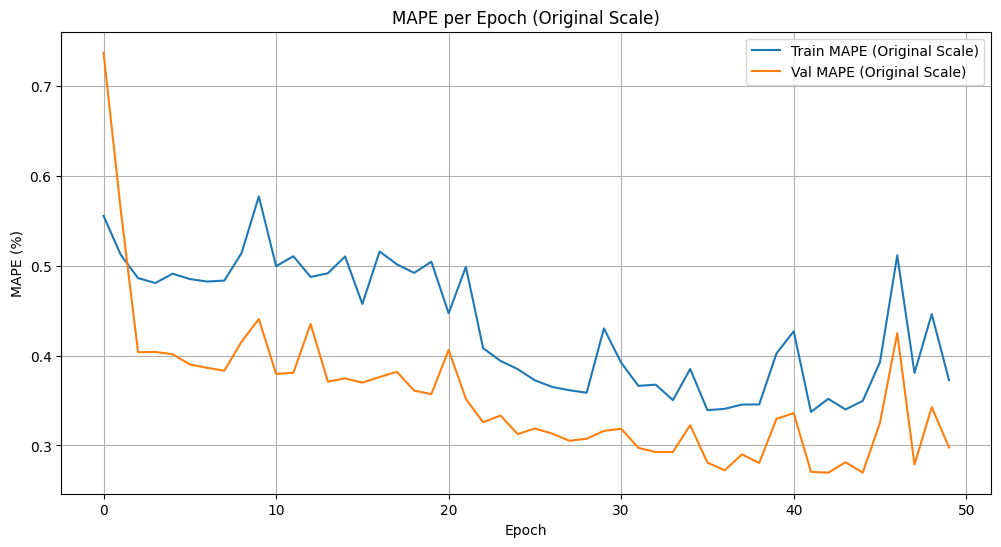

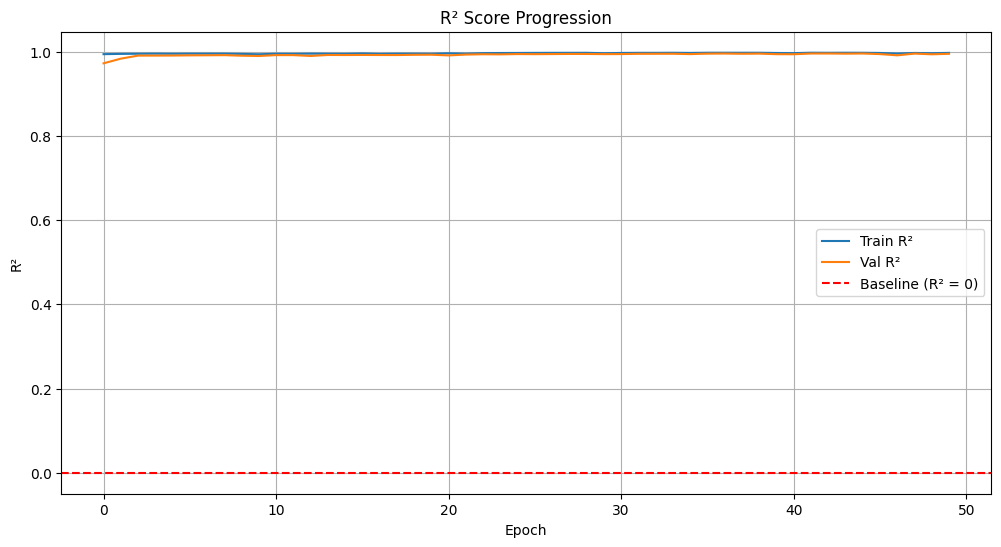

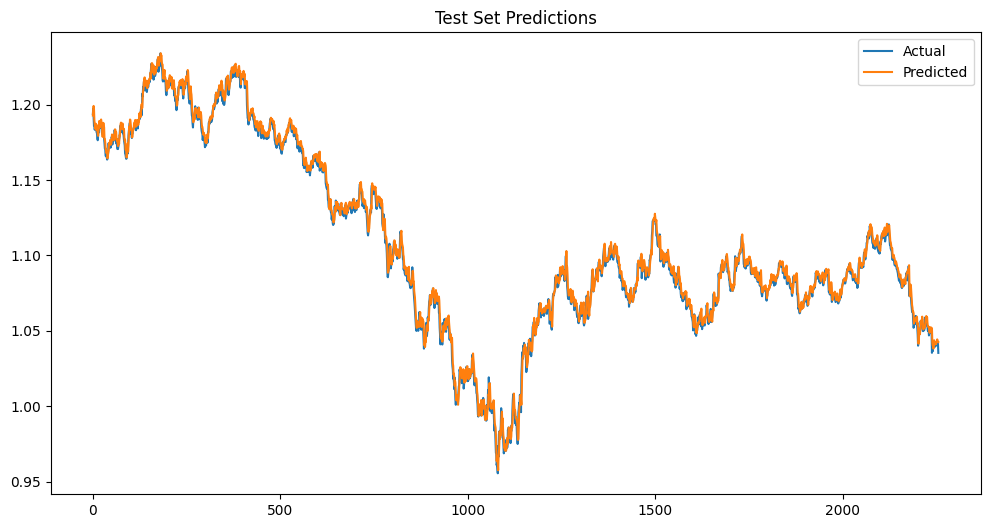

Train Metrics - MAE: 0.0047, RMSE: 0.0064, MAPE: 0.37%, R2: 0.9973
Test Metrics - MAE: 0.0033, RMSE: 0.0043, MAPE: 0.30%, R2: 0.9951
Epoch  5 | Train MAE: 0.0062, Val MAE: 0.0044 | Train MAPE: 0.49%, Val MAPE: 0.40% | Train RMSE: 0.0085, Val RMSE: 0.0058 | Train R²: 0.9952, Val R²: 0.9910
Epoch 10 | Train MAE: 0.0073, Val MAE: 0.0049 | Train MAPE: 0.58%, Val MAPE: 0.44% | Train RMSE: 0.0095, Val RMSE: 0.0061 | Train R²: 0.9940, Val R²: 0.9899
Epoch 15 | Train MAE: 0.0065, Val MAE: 0.0041 | Train MAPE: 0.51%, Val MAPE: 0.37% | Train RMSE: 0.0087, Val RMSE: 0.0054 | Train R²: 0.9950, Val R²: 0.9921
Epoch 20 | Train MAE: 0.0065, Val MAE: 0.0039 | Train MAPE: 0.50%, Val MAPE: 0.36% | Train RMSE: 0.0085, Val RMSE: 0.0051 | Train R²: 0.9951, Val R²: 0.9929
Epoch 25 | Train MAE: 0.0049, Val MAE: 0.0034 | Train MAPE: 0.38%, Val MAPE: 0.31% | Train RMSE: 0.0066, Val RMSE: 0.0046 | Train R²: 0.9970, Val R²: 0.9944
Epoch 30 | Train MAE: 0.0055, Val MAE: 0.0035 | Train MAPE: 0.43%, Val MAPE: 0.32%

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.callbacks import Callback

# Load and parse datetime correctly
df = pd.read_csv('EUROUSD_ASK_12HOURS.csv')
df.columns = ['Local time', 'Open', 'High', 'Low', 'Close', 'Volume']
df['Local time'] = pd.to_datetime(df['Local time'].str.split('\.').str[0], format='%d.%m.%Y %H:%M:%S', errors='coerce')
df = df[df['Volume'] > 0].copy()
df = df[['Open', 'High', 'Low', 'Close']].astype(float)

# Scale data
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df)

# Create sequences (exclude Close from input features)
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :-1])  # Use only Open, High, Low
        y.append(data[i+seq_length, -1])     # Predict Close
    return np.array(X), np.array(y)

SEQ_LENGTH = 3
X, y = create_sequences(scaled, SEQ_LENGTH)

# Split train/test
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build LSTM model
model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))  # Explicit Input layer
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(1))

# Custom RMSE metric
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

# Compile without MAPE (handled manually)
model.compile(optimizer='adam', loss='mse', metrics=['mae', rmse])

# Callback to track metrics on original scale
class MetricsCallback(Callback):
    def __init__(self, X_train, y_train, X_val, y_val, scaler, df):
        super().__init__()
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.scaler = scaler
        self.df = df
        self.metrics = {
            'train_mae': [], 'val_mae': [],
            'train_mape': [], 'val_mape': [],
            'train_rmse': [], 'val_rmse': [],
            'train_r2': [], 'val_r2': []
        }

    def on_epoch_end(self, epoch, logs=None):
        # Predict on train and validation data
        train_pred = self.model.predict(self.X_train, verbose=0).flatten()
        val_pred = self.model.predict(self.X_val, verbose=0).flatten()

        # Inverse transform predictions and actuals
        def inverse_transform(preds, X_original):
            dummy = np.zeros((len(preds), self.df.shape[1]))
            dummy[:, :-1] = X_original.reshape(-1, self.df.shape[1]-1)
            dummy[:, -1] = preds.ravel()
            dummy = self.scaler.inverse_transform(dummy)
            return dummy[:, -1]

        train_pred_inv = inverse_transform(train_pred, self.X_train[:, -1, :])
        val_pred_inv = inverse_transform(val_pred, self.X_val[:, -1, :])
        train_actuals_inv = inverse_transform(self.y_train, self.X_train[:, -1, :])
        val_actuals_inv = inverse_transform(self.y_val, self.X_val[:, -1, :])

        # Compute metrics
        def calculate_metrics(y_true, y_pred):
            mae = mean_absolute_error(y_true, y_pred)
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            mape = mean_absolute_percentage_error(y_true, y_pred) * 100
            r2 = r2_score(y_true, y_pred)
            return mae, mape, rmse, r2

        train_mae, train_mape, train_rmse, train_r2 = calculate_metrics(train_actuals_inv, train_pred_inv)
        val_mae, val_mape, val_rmse, val_r2 = calculate_metrics(val_actuals_inv, val_pred_inv)

        # Store metrics
        self.metrics['train_mae'].append(train_mae)
        self.metrics['val_mae'].append(val_mae)
        self.metrics['train_mape'].append(train_mape)
        self.metrics['val_mape'].append(val_mape)
        self.metrics['train_rmse'].append(train_rmse)
        self.metrics['val_rmse'].append(val_rmse)
        self.metrics['train_r2'].append(train_r2)
        self.metrics['val_r2'].append(val_r2)

        # Print every 5 epochs
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1:2d} | "
                  f"Train MAPE: {train_mape:.2f}%, Val MAPE: {val_mape:.2f}% | "
                  f"Train R²: {train_r2:.4f}, Val R²: {val_r2:.4f}")

# Initialize callback
metrics_callback = MetricsCallback(X_train, y_train, X_test, y_test, scaler, df)

# Train model
history_lstm = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[metrics_callback]
)

# Predictions
train_pred_lstm = model.predict(X_train).flatten()
test_pred_lstm = model.predict(X_test).flatten()

# Inverse transform predictions
def inverse_transform(preds, X_original):
    dummy = np.zeros((len(preds), df.shape[1]))
    dummy[:, :-1] = X_original.reshape(-1, df.shape[1]-1)
    dummy[:, -1] = preds.ravel()
    dummy = scaler.inverse_transform(dummy)
    return dummy[:, -1]

train_pred_inv_lstm = inverse_transform(train_pred_lstm, X_train[:, -1, :])
test_pred_inv_lstm = inverse_transform(test_pred_lstm, X_test[:, -1, :])

# Actual values (invert y_train/y_test using corresponding X)
train_actuals = inverse_transform(y_train, X_train[:, -1, :])
test_actuals = inverse_transform(y_test, X_test[:, -1, :])

# Compute final metrics
def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse_val = np.sqrt(mean_squared_error(y_true, y_pred))
    mape_val = mean_absolute_percentage_error(y_true, y_pred) * 100
    r2_val = r2_score(y_true, y_pred)
    return [mae, rmse_val, mape_val, r2_val]

train_metrics = evaluate(train_actuals, train_pred_inv_lstm)
test_metrics = evaluate(test_actuals, test_pred_inv_lstm)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(history_lstm.history['mae'], label='Train MAE (Scaled)')
plt.plot(history_lstm.history['val_mae'], label='Val MAE (Scaled)')
plt.plot(metrics_callback.metrics['train_mae'], label='Train MAE (Original Scale)')
plt.plot(metrics_callback.metrics['val_mae'], label='Val MAE (Original Scale)')
plt.legend()
plt.title('MAE per Epoch')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(metrics_callback.metrics['train_mape'], label='Train MAPE (Original Scale)')
plt.plot(metrics_callback.metrics['val_mape'], label='Val MAPE (Original Scale)')
plt.legend()
plt.title('MAPE per Epoch (Original Scale)')
plt.xlabel('Epoch')
plt.ylabel('MAPE (%)')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(metrics_callback.metrics['train_r2'], label='Train R²')
plt.plot(metrics_callback.metrics['val_r2'], label='Val R²')
plt.axhline(y=0, color='r', linestyle='--', label='Baseline (R² = 0)')
plt.legend()
plt.title('R² Score Progression')
plt.xlabel('Epoch')
plt.ylabel('R²')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(test_actuals, label='Actual')
plt.plot(test_pred_inv_lstm, label='Predicted')
plt.legend()
plt.title('Test Set Predictions')
plt.show()

# Print final metrics
print(f"Train Metrics - MAE: {train_metrics[0]:.4f}, RMSE: {train_metrics[1]:.4f}, MAPE: {train_metrics[2]:.2f}%, R2: {train_metrics[3]:.4f}")
print(f"Test Metrics - MAE: {test_metrics[0]:.4f}, RMSE: {test_metrics[1]:.4f}, MAPE: {test_metrics[2]:.2f}%, R2: {test_metrics[3]:.4f}")

# Print metrics every 5 epochs
for epoch in range(4, 50, 5):  # Starts from epoch 5 (index 4)
    print(f"Epoch {epoch+1:2d} | "
          f"Train MAE: {metrics_callback.metrics['train_mae'][epoch]:.4f}, "
          f"Val MAE: {metrics_callback.metrics['val_mae'][epoch]:.4f} | "
          f"Train MAPE: {metrics_callback.metrics['train_mape'][epoch]:.2f}%, "
          f"Val MAPE: {metrics_callback.metrics['val_mape'][epoch]:.2f}% | "
          f"Train RMSE: {metrics_callback.metrics['train_rmse'][epoch]:.4f}, "
          f"Val RMSE: {metrics_callback.metrics['val_rmse'][epoch]:.4f} | "
          f"Train R²: {metrics_callback.metrics['train_r2'][epoch]:.4f}, "
          f"Val R²: {metrics_callback.metrics['val_r2'][epoch]:.4f}")

**ANN** **NEW**

Epoch 1/50


<>:14: SyntaxWarning: invalid escape sequence '\.'
<>:14: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipython-input-3647764198.py:14: SyntaxWarning: invalid escape sequence '\.'
  df['Local time'] = pd.to_datetime(df['Local time'].str.split('\.').str[0], format='%d.%m.%Y %H:%M:%S', errors='coerce')


282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0032 - mae: 0.0309 - rmse: 0.2616 - val_loss: 5.1500e-05 - val_mae: 0.0054 - val_rmse: 0.0146
Epoch 2/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.2288e-04 - mae: 0.0081 - rmse: 0.2643 - val_loss: 5.3256e-05 - val_mae: 0.0055 - val_rmse: 0.0149
Epoch 3/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1923e-04 - mae: 0.0079 - rmse: 0.2598 - val_loss: 5.1158e-05 - val_mae: 0.0054 - val_rmse: 0.0149
Epoch 4/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.1294e-04 - mae: 0.0078 - rmse: 0.2611 - val_loss: 5.6500e-05 - val_mae: 0.0058 - val_rmse: 0.0153
Epoch 5/50
274/282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1372e-04 - mae: 0.0078 - rmse: 0.2619Epoch  5 | Train MAPE: 0.40%, Val MAPE: 0.32% | Train R²: 0.9969, Val R²: 0.9943
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1394e-04 - mae: 0.0078 - rmse: 0.2619 - val_loss: 5.1460e-05 - val_mae: 0.0055 - val_rmse: 0.0151
Epoch 6/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms

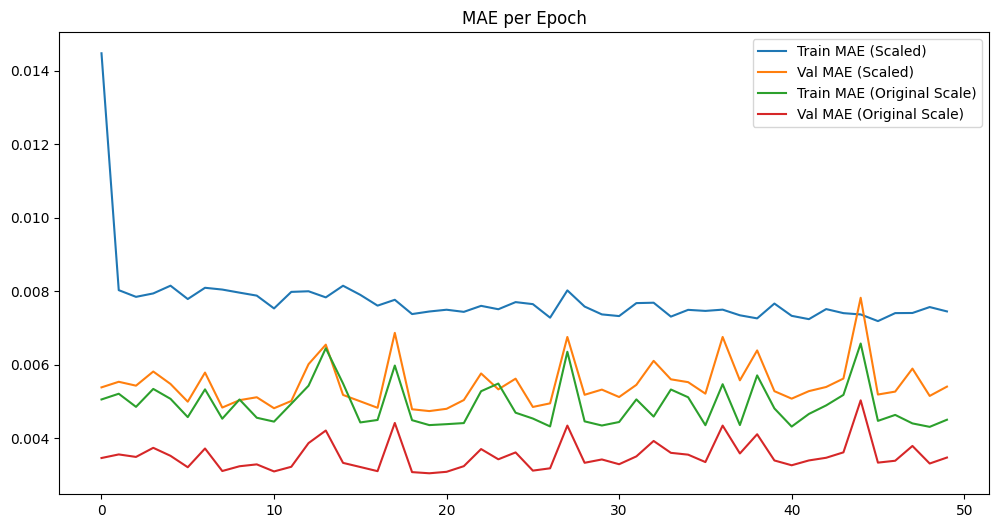

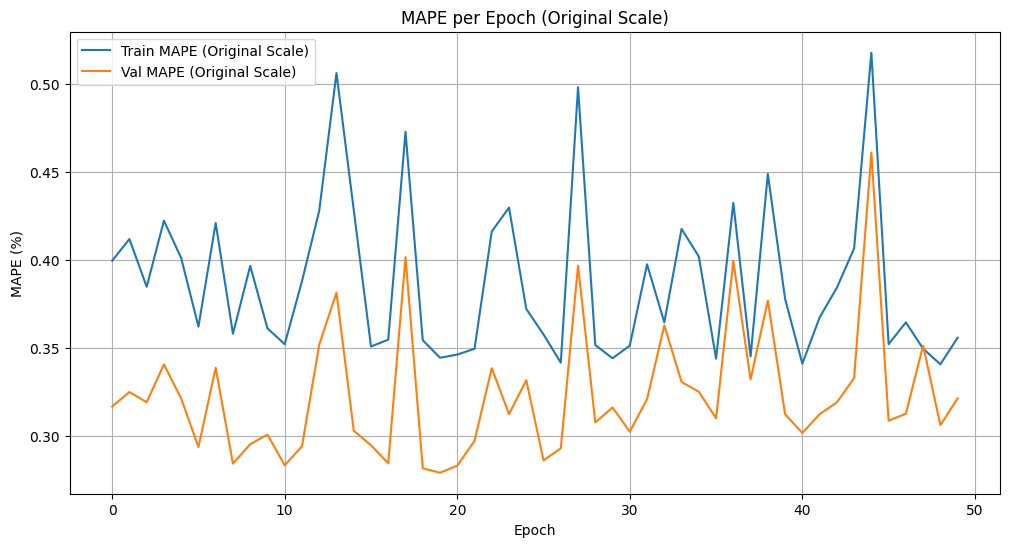

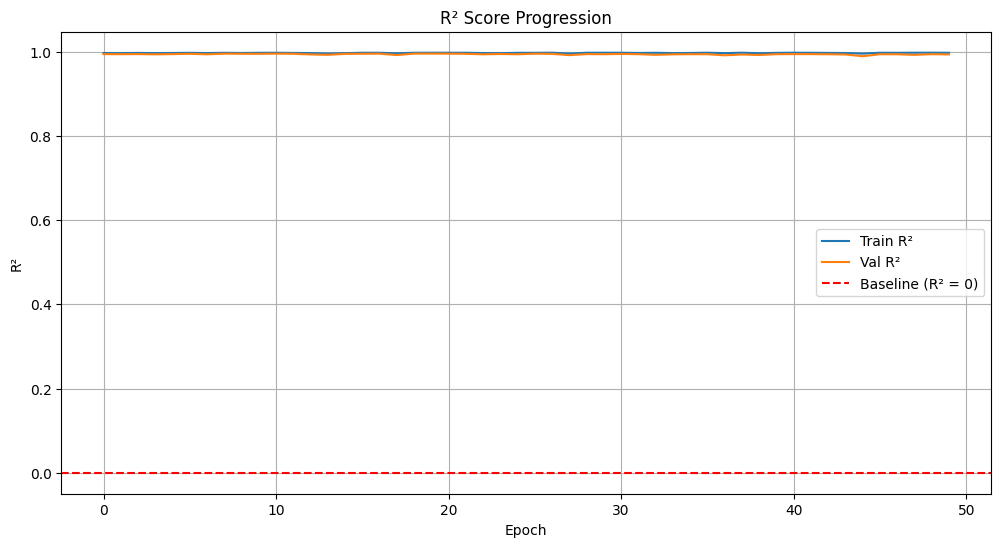

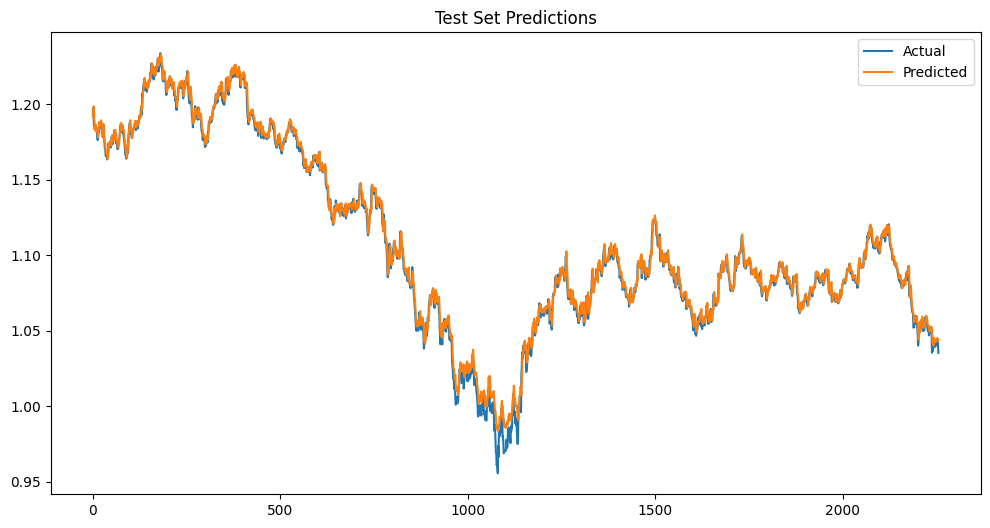

Train Metrics - MAE: 0.0045, RMSE: 0.0062, MAPE: 0.36%, R2: 0.9974
Test Metrics - MAE: 0.0035, RMSE: 0.0049, MAPE: 0.32%, R2: 0.9936
Epoch  5 | Train MAE: 0.0051, Val MAE: 0.0035 | Train MAPE: 0.40%, Val MAPE: 0.32% | Train RMSE: 0.0068, Val RMSE: 0.0046 | Train R²: 0.9969, Val R²: 0.9943
Epoch 10 | Train MAE: 0.0046, Val MAE: 0.0033 | Train MAPE: 0.36%, Val MAPE: 0.30% | Train RMSE: 0.0063, Val RMSE: 0.0044 | Train R²: 0.9974, Val R²: 0.9949
Epoch 15 | Train MAE: 0.0055, Val MAE: 0.0033 | Train MAPE: 0.43%, Val MAPE: 0.30% | Train RMSE: 0.0072, Val RMSE: 0.0044 | Train R²: 0.9965, Val R²: 0.9948
Epoch 20 | Train MAE: 0.0044, Val MAE: 0.0031 | Train MAPE: 0.34%, Val MAPE: 0.28% | Train RMSE: 0.0061, Val RMSE: 0.0041 | Train R²: 0.9975, Val R²: 0.9955
Epoch 25 | Train MAE: 0.0047, Val MAE: 0.0036 | Train MAPE: 0.37%, Val MAPE: 0.33% | Train RMSE: 0.0064, Val RMSE: 0.0047 | Train R²: 0.9973, Val R²: 0.9939
Epoch 30 | Train MAE: 0.0044, Val MAE: 0.0034 | Train MAPE: 0.34%, Val MAPE: 0.32%

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import Callback

# Load and parse datetime correctly
df = pd.read_csv('EUROUSD_ASK_12HOURS.csv')
df.columns = ['Local time', 'Open', 'High', 'Low', 'Close', 'Volume']
df['Local time'] = pd.to_datetime(df['Local time'].str.split('\.').str[0], format='%d.%m.%Y %H:%M:%S', errors='coerce')
df = df[df['Volume'] > 0].copy()
df = df[['Open', 'High', 'Low', 'Close']].astype(float)

# Scale data
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df)

# Create sequences (exclude Close from input features)
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :-1])  # Use only Open, High, Low
        y.append(data[i+seq_length, -1])     # Predict Close
    return np.array(X), np.array(y)

SEQ_LENGTH = 3
X, y = create_sequences(scaled, SEQ_LENGTH)

# Split train/test
split = int(0.8 * len(X))
X_train = X[:split]
X_test = X[split:]
y_train = y[:split]
y_test = y[split:]

# Reshape for ANN input
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)  # (samples, timesteps * features)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

# Build ANN model
model = Sequential()
model.add(Input(shape=(X_train_reshaped.shape[1],)))  # Flattened sequence
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

# Custom RMSE metric
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

# Compile model
model.compile(optimizer='adam', loss='mse', metrics=['mae', rmse])

# Callback to track metrics on original scale
class MetricsCallback(Callback):
    def __init__(self, X_train, y_train, X_val, y_val, scaler, df):
        super().__init__()
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.scaler = scaler
        self.df = df
        self.metrics = {
            'train_mae': [], 'val_mae': [],
            'train_mape': [], 'val_mape': [],
            'train_rmse': [], 'val_rmse': [],
            'train_r2': [], 'val_r2': []
        }

    def on_epoch_end(self, epoch, logs=None):
        # Reshape for ANN prediction
        X_train_reshaped = self.X_train.reshape(len(self.X_train), -1)
        X_val_reshaped = self.X_val.reshape(len(self.X_val), -1)

        train_pred = self.model.predict(X_train_reshaped, verbose=0).flatten()
        val_pred = self.model.predict(X_val_reshaped, verbose=0).flatten()

        # Use last time step features for inverse transform
        X_train_last = self.X_train[:, -1, :]
        X_val_last = self.X_val[:, -1, :]

        def inverse_transform(preds, X_original_last):
            dummy = np.zeros((len(preds), self.df.shape[1]))
            dummy[:, :-1] = X_original_last
            dummy[:, -1] = preds.ravel()
            dummy = self.scaler.inverse_transform(dummy)
            return dummy[:, -1]

        train_pred_inv = inverse_transform(train_pred, X_train_last)
        val_pred_inv = inverse_transform(val_pred, X_val_last)
        train_actuals_inv = inverse_transform(self.y_train, X_train_last)
        val_actuals_inv = inverse_transform(self.y_val, X_val_last)

        def calculate_metrics(y_true, y_pred):
            mae = mean_absolute_error(y_true, y_pred)
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            mape = mean_absolute_percentage_error(y_true, y_pred) * 100
            r2 = r2_score(y_true, y_pred)
            return mae, mape, rmse, r2

        train_mae, train_mape, train_rmse, train_r2 = calculate_metrics(train_actuals_inv, train_pred_inv)
        val_mae, val_mape, val_rmse, val_r2 = calculate_metrics(val_actuals_inv, val_pred_inv)

        self.metrics['train_mae'].append(train_mae)
        self.metrics['val_mae'].append(val_mae)
        self.metrics['train_mape'].append(train_mape)
        self.metrics['val_mape'].append(val_mape)
        self.metrics['train_rmse'].append(train_rmse)
        self.metrics['val_rmse'].append(val_rmse)
        self.metrics['train_r2'].append(train_r2)
        self.metrics['val_r2'].append(val_r2)

        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1:2d} | "
                  f"Train MAPE: {train_mape:.2f}%, Val MAPE: {val_mape:.2f}% | "
                  f"Train R²: {train_r2:.4f}, Val R²: {val_r2:.4f}")

# Initialize callback
metrics_callback = MetricsCallback(X_train, y_train, X_test, y_test, scaler, df)

# Train model
history_ann = model.fit(
    X_train_reshaped, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_reshaped, y_test),
    callbacks=[metrics_callback]
)

# Predictions
train_pred_ann = model.predict(X_train_reshaped).flatten()
test_pred_ann = model.predict(X_test_reshaped).flatten()

# Inverse transform predictions
def inverse_transform(preds, X_original_last):
    dummy = np.zeros((len(preds), df.shape[1]))
    dummy[:, :-1] = X_original_last
    dummy[:, -1] = preds.ravel()
    dummy = scaler.inverse_transform(dummy)
    return dummy[:, -1]

train_pred_inv_ann = inverse_transform(train_pred_ann, X_train[:, -1, :])
test_pred_inv_ann = inverse_transform(test_pred_ann, X_test[:, -1, :])

# Actual values (invert y_train/y_test using corresponding X)
train_actuals = inverse_transform(y_train, X_train[:, -1, :])
test_actuals = inverse_transform(y_test, X_test[:, -1, :])

# Compute final metrics
def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse_val = np.sqrt(mean_squared_error(y_true, y_pred))
    mape_val = mean_absolute_percentage_error(y_true, y_pred) * 100
    r2_val = r2_score(y_true, y_pred)
    return [mae, rmse_val, mape_val, r2_val]

train_metrics_ann = evaluate(train_actuals, train_pred_inv_ann)
test_metrics_ann = evaluate(test_actuals, test_pred_inv_ann)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(history_ann.history['mae'], label='Train MAE (Scaled)')
plt.plot(history_ann.history['val_mae'], label='Val MAE (Scaled)')
plt.plot(metrics_callback.metrics['train_mae'], label='Train MAE (Original Scale)')
plt.plot(metrics_callback.metrics['val_mae'], label='Val MAE (Original Scale)')
plt.legend()
plt.title('MAE per Epoch')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(metrics_callback.metrics['train_mape'], label='Train MAPE (Original Scale)')
plt.plot(metrics_callback.metrics['val_mape'], label='Val MAPE (Original Scale)')
plt.legend()
plt.title('MAPE per Epoch (Original Scale)')
plt.xlabel('Epoch')
plt.ylabel('MAPE (%)')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(metrics_callback.metrics['train_r2'], label='Train R²')
plt.plot(metrics_callback.metrics['val_r2'], label='Val R²')
plt.axhline(y=0, color='r', linestyle='--', label='Baseline (R² = 0)')
plt.legend()
plt.title('R² Score Progression')
plt.xlabel('Epoch')
plt.ylabel('R²')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(test_actuals, label='Actual')
plt.plot(test_pred_inv_ann, label='Predicted')
plt.legend()
plt.title('Test Set Predictions')
plt.show()

# Print final metrics
print(f"Train Metrics - MAE: {train_metrics_ann[0]:.4f}, RMSE: {train_metrics_ann[1]:.4f}, MAPE: {train_metrics_ann[2]:.2f}%, R2: {train_metrics_ann[3]:.4f}")
print(f"Test Metrics - MAE: {test_metrics_ann[0]:.4f}, RMSE: {test_metrics_ann[1]:.4f}, MAPE: {test_metrics_ann[2]:.2f}%, R2: {test_metrics_ann[3]:.4f}")

# Print metrics every 5 epochs
for epoch in range(4, 50, 5):  # Starts from epoch 5 (index 4)
    print(f"Epoch {epoch+1:2d} | "
          f"Train MAE: {metrics_callback.metrics['train_mae'][epoch]:.4f}, "
          f"Val MAE: {metrics_callback.metrics['val_mae'][epoch]:.4f} | "
          f"Train MAPE: {metrics_callback.metrics['train_mape'][epoch]:.2f}%, "
          f"Val MAPE: {metrics_callback.metrics['val_mape'][epoch]:.2f}% | "
          f"Train RMSE: {metrics_callback.metrics['train_rmse'][epoch]:.4f}, "
          f"Val RMSE: {metrics_callback.metrics['val_rmse'][epoch]:.4f} | "
          f"Train R²: {metrics_callback.metrics['train_r2'][epoch]:.4f}, "
          f"Val R²: {metrics_callback.metrics['val_r2'][epoch]:.4f}")

**CNN** **NEW**

Epoch 1/50


<>:14: SyntaxWarning: invalid escape sequence '\.'
<>:14: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipython-input-2454966769.py:14: SyntaxWarning: invalid escape sequence '\.'
  df['Local time'] = pd.to_datetime(df['Local time'].str.split('\.').str[0], format='%d.%m.%Y %H:%M:%S', errors='coerce')


282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0153 - mae: 0.0634 - rmse: 0.2695 - val_loss: 7.3774e-05 - val_mae: 0.0066 - val_rmse: 0.0149
Epoch 2/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.6448e-04 - mae: 0.0093 - rmse: 0.2645 - val_loss: 7.0135e-05 - val_mae: 0.0063 - val_rmse: 0.0148
Epoch 3/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.5803e-04 - mae: 0.0092 - rmse: 0.2591 - val_loss: 6.9465e-05 - val_mae: 0.0065 - val_rmse: 0.0149
Epoch 4/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.6479e-04 - mae: 0.0094 - rmse: 0.2615 - val_loss: 6.6179e-05 - val_mae: 0.0062 - val_rmse: 0.0148
Epoch 5/50
266/282 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5499e-04 - mae: 0.0092 - rmse: 0.2636Epoch  5 | Train MAPE: 0.46%, Val MAPE: 0.36% | Train R²: 0.9956, Val R²: 0.9927
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.5528e-04 - mae: 0.0092 - rmse: 0.2635 - val_loss: 6.5196e-05 - val_mae: 0.0061 - val_rmse: 0.0148
Epoch 6/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms

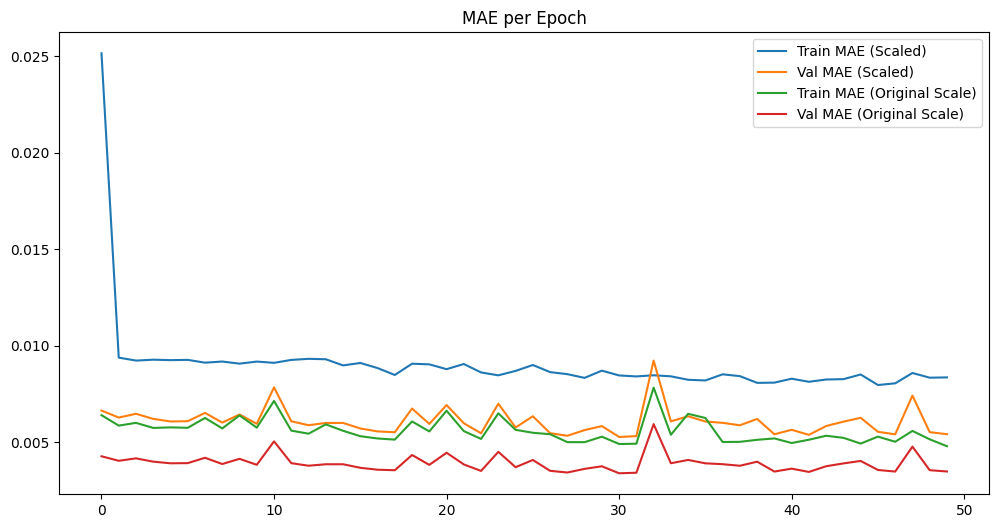

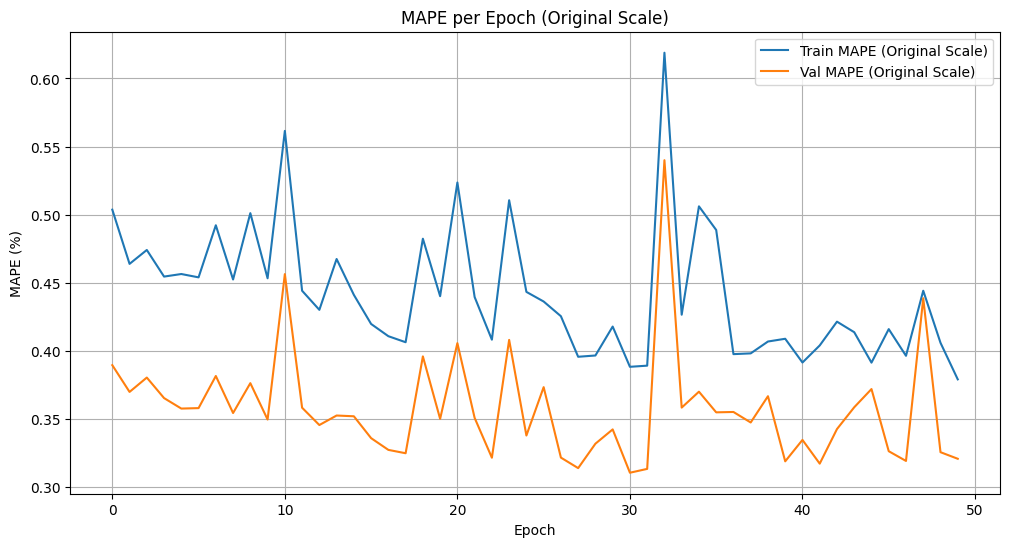

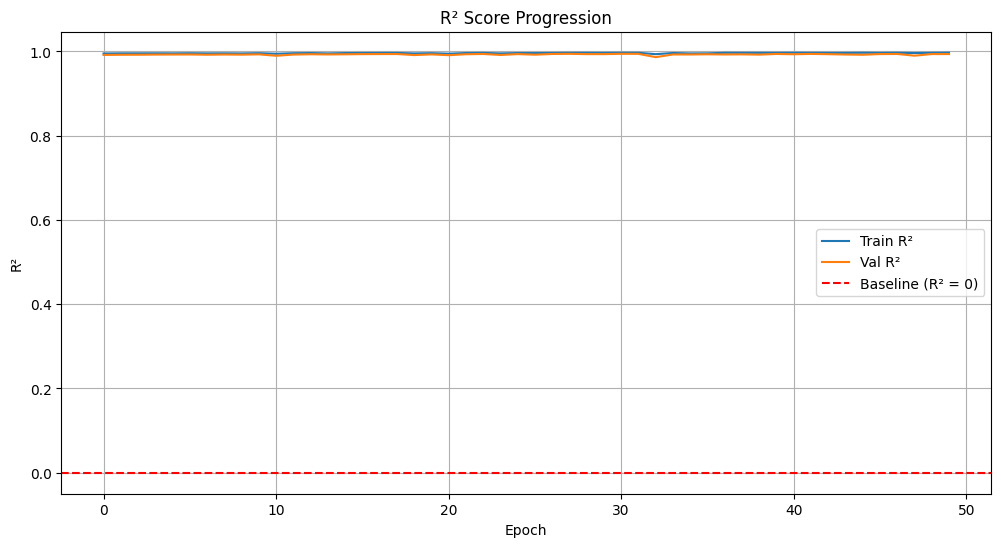

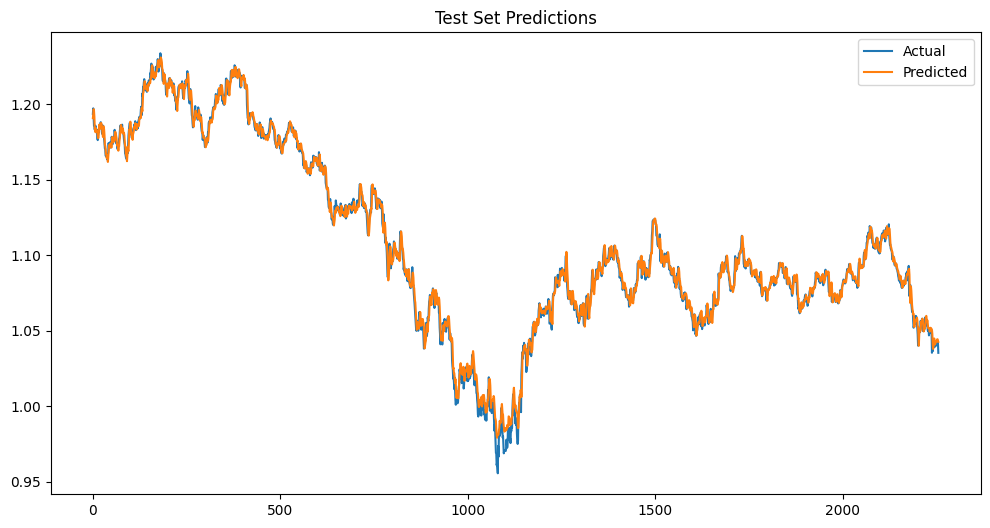

Train Metrics - MAE: 0.0048, RMSE: 0.0066, MAPE: 0.38%, R2: 0.9971
Test Metrics - MAE: 0.0035, RMSE: 0.0048, MAPE: 0.32%, R2: 0.9939
Epoch  5 | Train MAE: 0.0058, Val MAE: 0.0039 | Train MAPE: 0.46%, Val MAPE: 0.36% | Train RMSE: 0.0081, Val RMSE: 0.0052 | Train R²: 0.9956, Val R²: 0.9927
Epoch 10 | Train MAE: 0.0058, Val MAE: 0.0038 | Train MAPE: 0.45%, Val MAPE: 0.35% | Train RMSE: 0.0077, Val RMSE: 0.0050 | Train R²: 0.9960, Val R²: 0.9932
Epoch 15 | Train MAE: 0.0056, Val MAE: 0.0039 | Train MAPE: 0.44%, Val MAPE: 0.35% | Train RMSE: 0.0075, Val RMSE: 0.0050 | Train R²: 0.9963, Val R²: 0.9933
Epoch 20 | Train MAE: 0.0056, Val MAE: 0.0038 | Train MAPE: 0.44%, Val MAPE: 0.35% | Train RMSE: 0.0077, Val RMSE: 0.0051 | Train R²: 0.9960, Val R²: 0.9931
Epoch 25 | Train MAE: 0.0056, Val MAE: 0.0037 | Train MAPE: 0.44%, Val MAPE: 0.34% | Train RMSE: 0.0074, Val RMSE: 0.0048 | Train R²: 0.9963, Val R²: 0.9938
Epoch 30 | Train MAE: 0.0053, Val MAE: 0.0038 | Train MAPE: 0.42%, Val MAPE: 0.34%

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Input
from tensorflow.keras.callbacks import Callback

# Load and parse datetime correctly
df = pd.read_csv('EUROUSD_ASK_12HOURS.csv')
df.columns = ['Local time', 'Open', 'High', 'Low', 'Close', 'Volume']
df['Local time'] = pd.to_datetime(df['Local time'].str.split('\.').str[0], format='%d.%m.%Y %H:%M:%S', errors='coerce')
df = df[df['Volume'] > 0].copy()
df = df[['Open', 'High', 'Low', 'Close']].astype(float)

# Scale data
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df)

# Create sequences (exclude Close from input features)
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :-1])  # Use only Open, High, Low
        y.append(data[i+seq_length, -1])     # Predict Close
    return np.array(X), np.array(y)

SEQ_LENGTH = 3
X, y = create_sequences(scaled, SEQ_LENGTH)

# Split train/test
split = int(0.8 * len(X))
X_train = X[:split]
X_test = X[split:]
y_train = y[:split]
y_test = y[split:]

# Build CNN model
model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))  # (timesteps, features)
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

# Custom RMSE metric
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

# Compile model
model.compile(optimizer='adam', loss='mse', metrics=['mae', rmse])

# Callback to track metrics on original scale
class MetricsCallback(Callback):
    def __init__(self, X_train, y_train, X_val, y_val, scaler, df):
        super().__init__()
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.scaler = scaler
        self.df = df
        self.metrics = {
            'train_mae': [], 'val_mae': [],
            'train_mape': [], 'val_mape': [],
            'train_rmse': [], 'val_rmse': [],
            'train_r2': [], 'val_r2': []
        }

    def on_epoch_end(self, epoch, logs=None):
        # Predict on train and validation data
        train_pred = self.model.predict(self.X_train, verbose=0).flatten()
        val_pred = self.model.predict(self.X_val, verbose=0).flatten()

        # Use last time step features for inverse transform
        X_train_last = self.X_train[:, -1, :]
        X_val_last = self.X_val[:, -1, :]

        def inverse_transform(preds, X_original_last):
            dummy = np.zeros((len(preds), self.df.shape[1]))
            dummy[:, :-1] = X_original_last
            dummy[:, -1] = preds.ravel()
            dummy = self.scaler.inverse_transform(dummy)
            return dummy[:, -1]

        train_pred_inv = inverse_transform(train_pred, X_train_last)
        val_pred_inv = inverse_transform(val_pred, X_val_last)
        train_actuals_inv = inverse_transform(self.y_train, X_train_last)
        val_actuals_inv = inverse_transform(self.y_val, X_val_last)

        def calculate_metrics(y_true, y_pred):
            mae = mean_absolute_error(y_true, y_pred)
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            mape = mean_absolute_percentage_error(y_true, y_pred) * 100
            r2 = r2_score(y_true, y_pred)
            return mae, mape, rmse, r2

        train_mae, train_mape, train_rmse, train_r2 = calculate_metrics(train_actuals_inv, train_pred_inv)
        val_mae, val_mape, val_rmse, val_r2 = calculate_metrics(val_actuals_inv, val_pred_inv)

        self.metrics['train_mae'].append(train_mae)
        self.metrics['val_mae'].append(val_mae)
        self.metrics['train_mape'].append(train_mape)
        self.metrics['val_mape'].append(val_mape)
        self.metrics['train_rmse'].append(train_rmse)
        self.metrics['val_rmse'].append(val_rmse)
        self.metrics['train_r2'].append(train_r2)
        self.metrics['val_r2'].append(val_r2)

        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1:2d} | "
                  f"Train MAPE: {train_mape:.2f}%, Val MAPE: {val_mape:.2f}% | "
                  f"Train R²: {train_r2:.4f}, Val R²: {val_r2:.4f}")

# Initialize callback
metrics_callback = MetricsCallback(X_train, y_train, X_test, y_test, scaler, df)

# Train model
history_cnn = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[metrics_callback]
)

# Predictions
train_pred_cnn = model.predict(X_train).flatten()
test_pred_cnn = model.predict(X_test).flatten()

# Inverse transform predictions
def inverse_transform(preds, X_original_last):
    dummy = np.zeros((len(preds), df.shape[1]))
    dummy[:, :-1] = X_original_last
    dummy[:, -1] = preds.ravel()
    dummy = scaler.inverse_transform(dummy)
    return dummy[:, -1]

train_pred_inv_cnn = inverse_transform(train_pred_cnn, X_train[:, -1, :])
test_pred_inv_cnn = inverse_transform(test_pred_cnn, X_test[:, -1, :])

# Actual values (invert y_train/y_test using corresponding X)
train_actuals = inverse_transform(y_train, X_train[:, -1, :])
test_actuals = inverse_transform(y_test, X_test[:, -1, :])

# Compute final metrics
def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse_val = np.sqrt(mean_squared_error(y_true, y_pred))
    mape_val = mean_absolute_percentage_error(y_true, y_pred) * 100
    r2_val = r2_score(y_true, y_pred)
    return [mae, rmse_val, mape_val, r2_val]

train_metrics_cnn = evaluate(train_actuals, train_pred_inv_cnn)
test_metrics_cnn = evaluate(test_actuals, test_pred_inv_cnn)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(history_cnn.history['mae'], label='Train MAE (Scaled)')
plt.plot(history_cnn.history['val_mae'], label='Val MAE (Scaled)')
plt.plot(metrics_callback.metrics['train_mae'], label='Train MAE (Original Scale)')
plt.plot(metrics_callback.metrics['val_mae'], label='Val MAE (Original Scale)')
plt.legend()
plt.title('MAE per Epoch')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(metrics_callback.metrics['train_mape'], label='Train MAPE (Original Scale)')
plt.plot(metrics_callback.metrics['val_mape'], label='Val MAPE (Original Scale)')
plt.legend()
plt.title('MAPE per Epoch (Original Scale)')
plt.xlabel('Epoch')
plt.ylabel('MAPE (%)')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(metrics_callback.metrics['train_r2'], label='Train R²')
plt.plot(metrics_callback.metrics['val_r2'], label='Val R²')
plt.axhline(y=0, color='r', linestyle='--', label='Baseline (R² = 0)')
plt.legend()
plt.title('R² Score Progression')
plt.xlabel('Epoch')
plt.ylabel('R²')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(test_actuals, label='Actual')
plt.plot(test_pred_inv_cnn, label='Predicted')
plt.legend()
plt.title('Test Set Predictions')
plt.show()

# Print final metrics
print(f"Train Metrics - MAE: {train_metrics_cnn[0]:.4f}, RMSE: {train_metrics_cnn[1]:.4f}, MAPE: {train_metrics_cnn[2]:.2f}%, R2: {train_metrics_cnn[3]:.4f}")
print(f"Test Metrics - MAE: {test_metrics_cnn[0]:.4f}, RMSE: {test_metrics_cnn[1]:.4f}, MAPE: {test_metrics_cnn[2]:.2f}%, R2: {test_metrics_cnn[3]:.4f}")

# Print metrics every 5 epochs
for epoch in range(4, 50, 5):  # Starts from epoch 5 (index 4)
    print(f"Epoch {epoch+1:2d} | "
          f"Train MAE: {metrics_callback.metrics['train_mae'][epoch]:.4f}, "
          f"Val MAE: {metrics_callback.metrics['val_mae'][epoch]:.4f} | "
          f"Train MAPE: {metrics_callback.metrics['train_mape'][epoch]:.2f}%, "
          f"Val MAPE: {metrics_callback.metrics['val_mape'][epoch]:.2f}% | "
          f"Train RMSE: {metrics_callback.metrics['train_rmse'][epoch]:.4f}, "
          f"Val RMSE: {metrics_callback.metrics['val_rmse'][epoch]:.4f} | "
          f"Train R²: {metrics_callback.metrics['train_r2'][epoch]:.4f}, "
          f"Val R²: {metrics_callback.metrics['val_r2'][epoch]:.4f}")

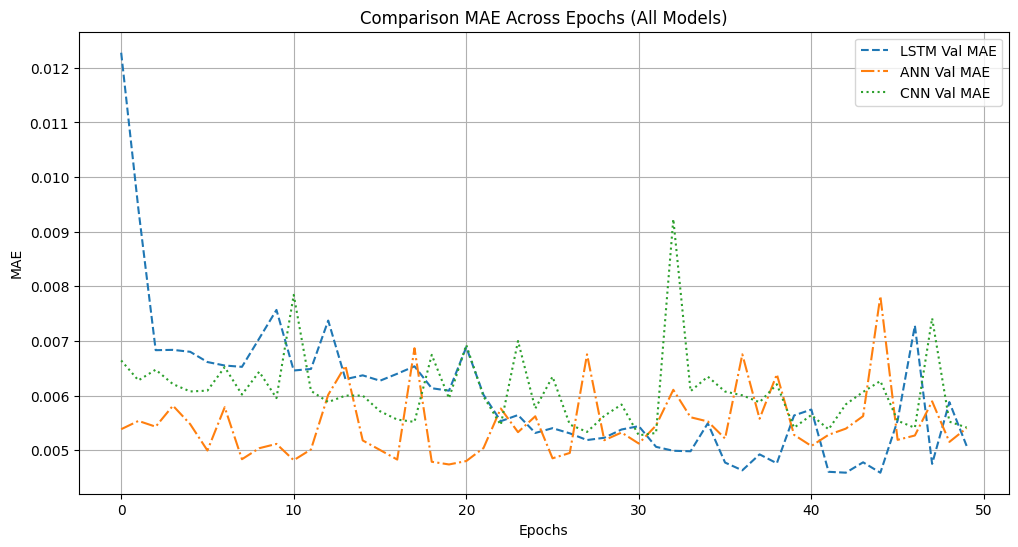

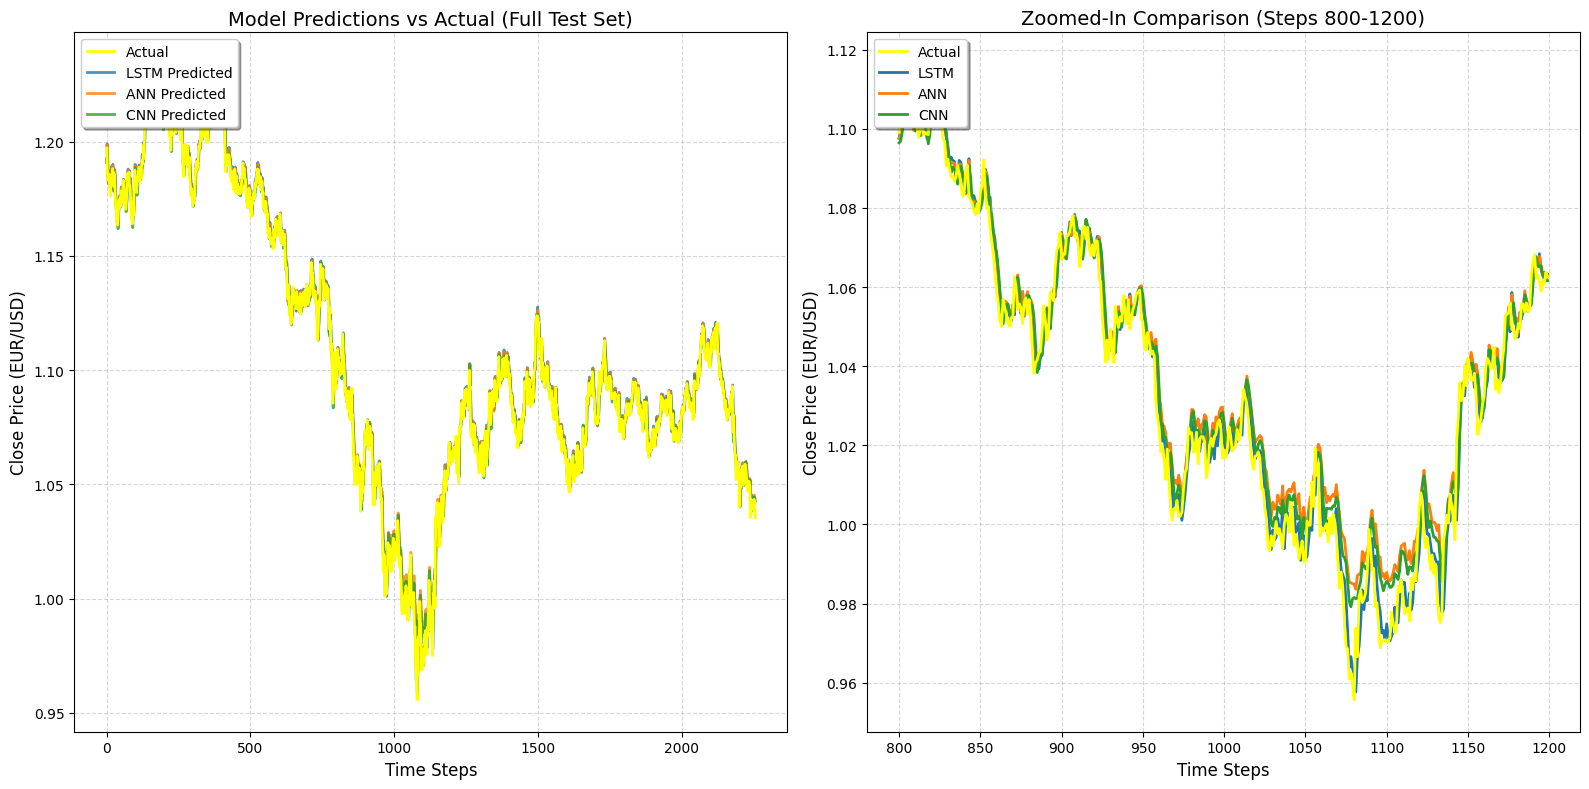

In [18]:
plt.figure(figsize=(12, 6))
# Plot LSTM
plt.plot(history_lstm.history['val_mae'], label='LSTM Val MAE', linestyle='--')
# Plot ANN
plt.plot(history_ann.history['val_mae'], label='ANN Val MAE', linestyle='-.')
# Plot CNN
plt.plot(history_cnn.history['val_mae'], label='CNN Val MAE', linestyle=':')
plt.legend()
plt.title('Comparison MAE Across Epochs (All Models)')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.grid(True)
plt.show()

# Plotting with enhanced clarity and custom zoom
plt.figure(figsize=(16, 8))

# Full test set comparison (unchanged)
plt.subplot(1, 2, 1)
plt.plot(test_actuals, label='Actual', color='yellow', linewidth=2, zorder=5)
plt.plot(test_pred_inv_lstm, label='LSTM Predicted', color='tab:blue', linestyle='-', linewidth=2, alpha=0.8)
plt.plot(test_pred_inv_ann, label='ANN Predicted', color='tab:orange', linestyle='-', linewidth=2, alpha=0.8)
plt.plot(test_pred_inv_cnn, label='CNN Predicted', color='tab:green', linestyle='-', linewidth=2, alpha=0.8)

plt.title('Model Predictions vs Actual (Full Test Set)', fontsize=14)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Close Price (EUR/USD)', fontsize=12)
plt.legend(loc='upper left', fontsize=10, frameon=True, fancybox=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Zoomed-in subplot (focus on steps 800–1200)
zoom_start = 800
zoom_end = 1200

# Check if indices are valid
if zoom_end < len(test_actuals):
    plt.subplot(1, 2, 2)
    plt.plot(
        np.arange(zoom_start, zoom_end),
        test_actuals[zoom_start:zoom_end],
        label='Actual', color='yellow', linewidth=2, zorder=5
    )
    plt.plot(
        np.arange(zoom_start, zoom_end),
        test_pred_inv_lstm[zoom_start:zoom_end],
        label='LSTM', color='tab:blue', linestyle='-', linewidth=2
    )
    plt.plot(
        np.arange(zoom_start, zoom_end),
        test_pred_inv_ann[zoom_start:zoom_end],
        label='ANN', color='tab:orange', linestyle='-', linewidth=2
    )
    plt.plot(
        np.arange(zoom_start, zoom_end),
        test_pred_inv_cnn[zoom_start:zoom_end],
        label='CNN', color='tab:green', linestyle='-', linewidth=2
    )

    plt.title(f'Zoomed-In Comparison (Steps {zoom_start}-{zoom_end})', fontsize=14)
    plt.xlabel('Time Steps', fontsize=12)
    plt.ylabel('Close Price (EUR/USD)', fontsize=12)
    plt.legend(loc='upper left', fontsize=10, frameon=True, fancybox=True, shadow=True)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
else:
    print(f"Error: Zoom range exceeds test data length ({len(test_actuals)} steps). Adjust zoom_start/zoom_end.")

plt.show()

**ELLIOT** **WAVE**

Training Metrics:
MAE: 0.0065
RMSE: 0.0087
MAPE: 0.5100
R2: 0.9950

Testing Metrics:
MAE: 0.0043
RMSE: 0.0057
MAPE: 0.3890
R2: 0.9914


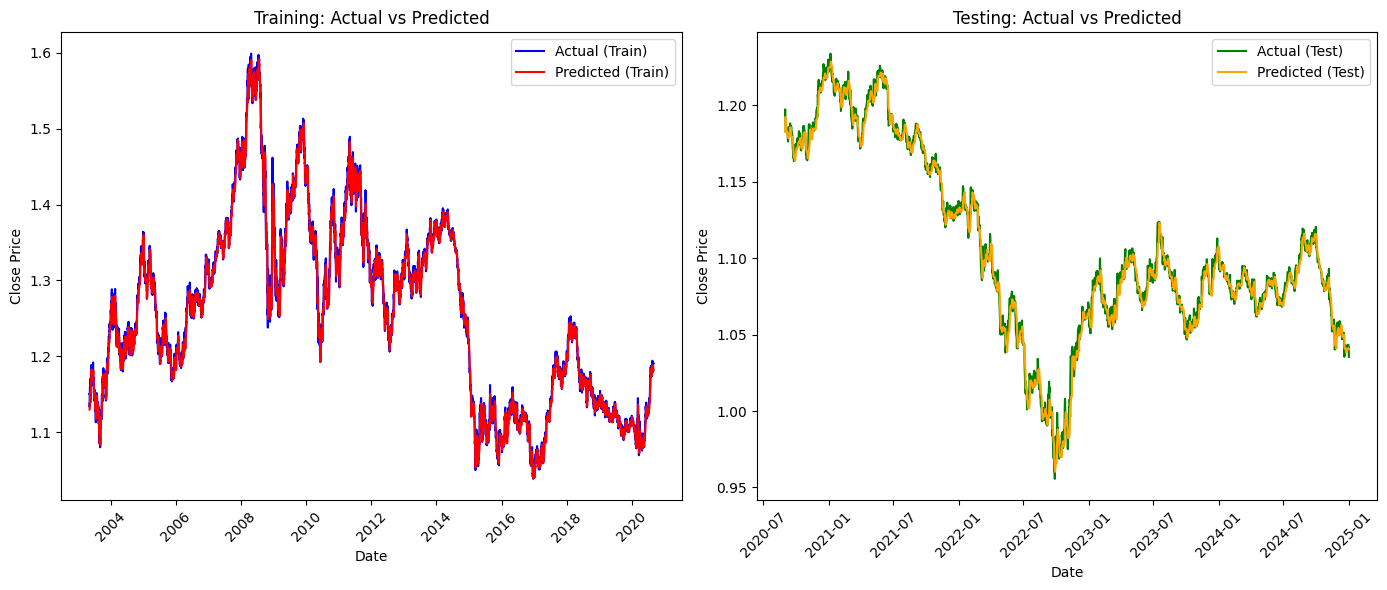

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score, mean_absolute_error # Import mean_absolute_error here

# Load and preprocess data
# Remove header=None and names parameters to use the first row as header
# Remove explicit dtype specification if columns are consistently numeric after header is handled
df = pd.read_csv("EUROUSD_ASK_12HOURS.csv")

# Ensure column names are as expected (adjust if the actual header names are different)
# Assuming the header row contains 'Local time', 'Open', 'High', 'Low', 'Close', 'Volume'
df.columns = ['datetime', 'Open', 'High', 'Low', 'Close', 'Volume']


# Explicitly convert numeric columns to float after loading
# This handles cases where some rows might have non-numeric data that wasn't caught by read_csv
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce') # Use errors='coerce' to turn non-numeric into NaN

# Drop rows where volume is NaN after coercion
df = df.dropna(subset=['Volume'])
df = df[df['Volume'] > 0].copy()

# Parse datetime correctly
# Adjust the regex if necessary based on the actual datetime string format in the CSV
df['datetime'] = pd.to_datetime(df['datetime'].astype(str).str.replace(r'\.\d+ GMT\+\d+$', '', regex=True), format='%d.%m.%Y %H:%M:%S', errors='coerce')

# Drop rows where datetime parsing failed
df = df.dropna(subset=['datetime'])


df = df.sort_values('datetime').reset_index(drop=True)

# Generate predictions using Fibonacci retracement (61.8% level)
predicted_closes = []
actual_closes = []

# Ensure we have enough data for the initial window
if len(df) >= 5:
    for i in range(5, len(df)):
        window = df.iloc[i-5:i]
        high = window['High'].max()
        low = window['Low'].min()
        diff = high - low
        pred_close = high - 0.618 * diff  # 61.8% retracement
        predicted_closes.append(pred_close)
        actual_closes.append(df.iloc[i]['Close'])

    # Convert to numpy arrays
    actual = np.array(actual_closes)
    predicted = np.array(predicted_closes)
    # Ensure dates align with actual/predicted by starting from the 5th index
    dates = df['datetime'].iloc[5:].reset_index(drop=True)


    # Split into train and test (80/20)
    split_idx = int(len(actual) * 0.8)
    train_actual, test_actual = actual[:split_idx], actual[split_idx:]
    train_pred_ew, test_pred_ew = predicted[:split_idx], predicted[split_idx:]
    train_dates, test_dates = dates[:split_idx], dates[split_idx:]

    # Evaluate model
    def evaluate_model(y_true, y_pred):
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mape = mean_absolute_percentage_error(y_true, y_pred) * 100
        r2 = r2_score(y_true, y_pred)
        return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'R2': r2}

    train_metrics_ew = evaluate_model(train_actual, train_pred_ew)
    test_metrics_ew = evaluate_model(test_actual, test_pred_ew)

    # Print metrics
    print("Training Metrics:")
    # Corrected: Use train_metrics_ew (which is a dictionary) instead of train_metrics (which is a list)
    for k, v in train_metrics_ew.items():
        print(f"{k}: {v:.4f}")

    print("\nTesting Metrics:")
    # Corrected: Use test_metrics_ew (which is a dictionary) instead of test_metrics (which is a list)
    for k, v in test_metrics_ew.items():
        print(f"{k}: {v:.4f}")

    # Plotting
    plt.figure(figsize=(14, 6))

    # Training plot
    plt.subplot(1, 2, 1)
    plt.plot(train_dates, train_actual, label='Actual (Train)', color='blue')
    plt.plot(train_dates, train_pred_ew, label='Predicted (Train)', color='red')
    plt.title('Training: Actual vs Predicted')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.xticks(rotation=45)
    plt.legend()

    # Testing plot
    plt.subplot(1, 2, 2)
    plt.plot(test_dates, test_actual, label='Actual (Test)', color='green')
    plt.plot(test_dates, test_pred_ew, label='Predicted (Test)', color='orange')
    plt.title('Testing: Actual vs Predicted')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.xticks(rotation=45)
    plt.legend()

    plt.tight_layout()
    plt.show()
else:
    print("Not enough data points in the dataframe to perform analysis with a window size of 5.")

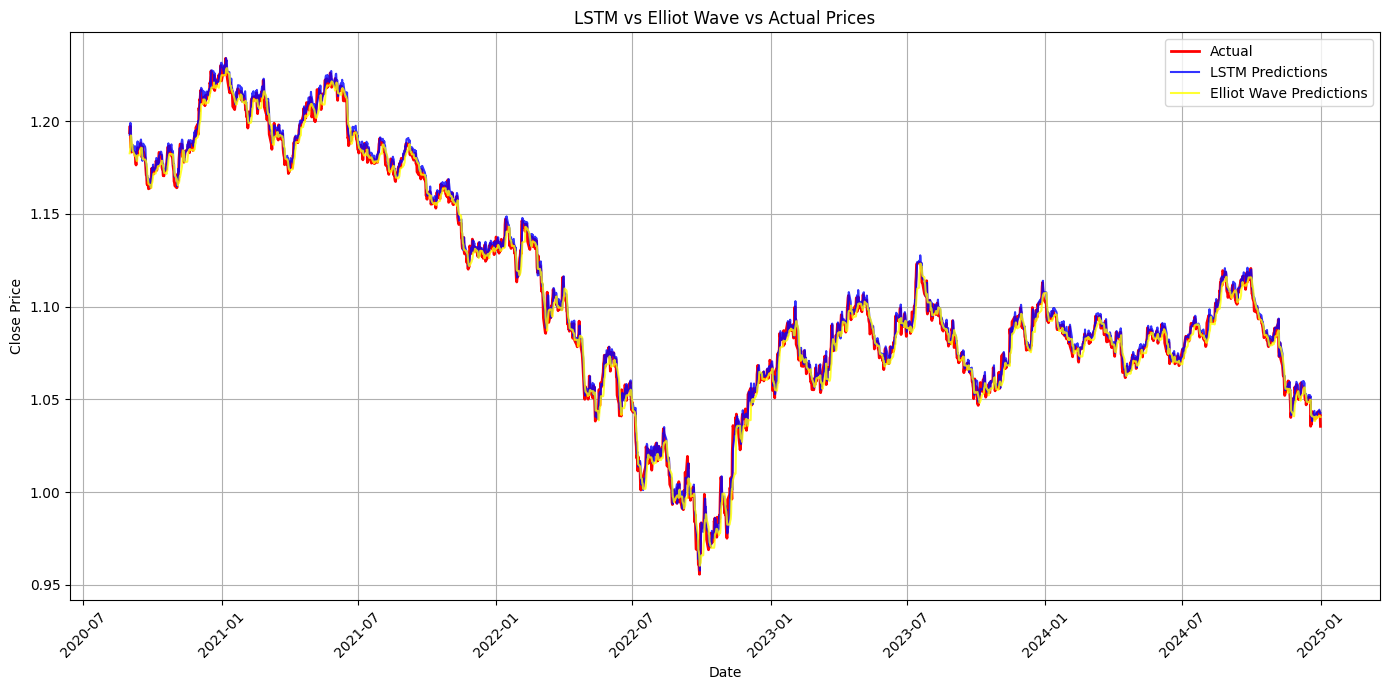

In [20]:
# 1. Direct Comparison Visualization
plt.figure(figsize=(14, 7))
plt.plot(test_dates, test_actual, label='Actual', color='red', linewidth=2)
plt.plot(test_dates, test_pred_inv_lstm, label='LSTM Predictions', color='blue', alpha=0.8)
plt.plot(test_dates, test_pred_ew, label='Elliot Wave Predictions', color='yellow', alpha=0.8)
plt.title('LSTM vs Elliot Wave vs Actual Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

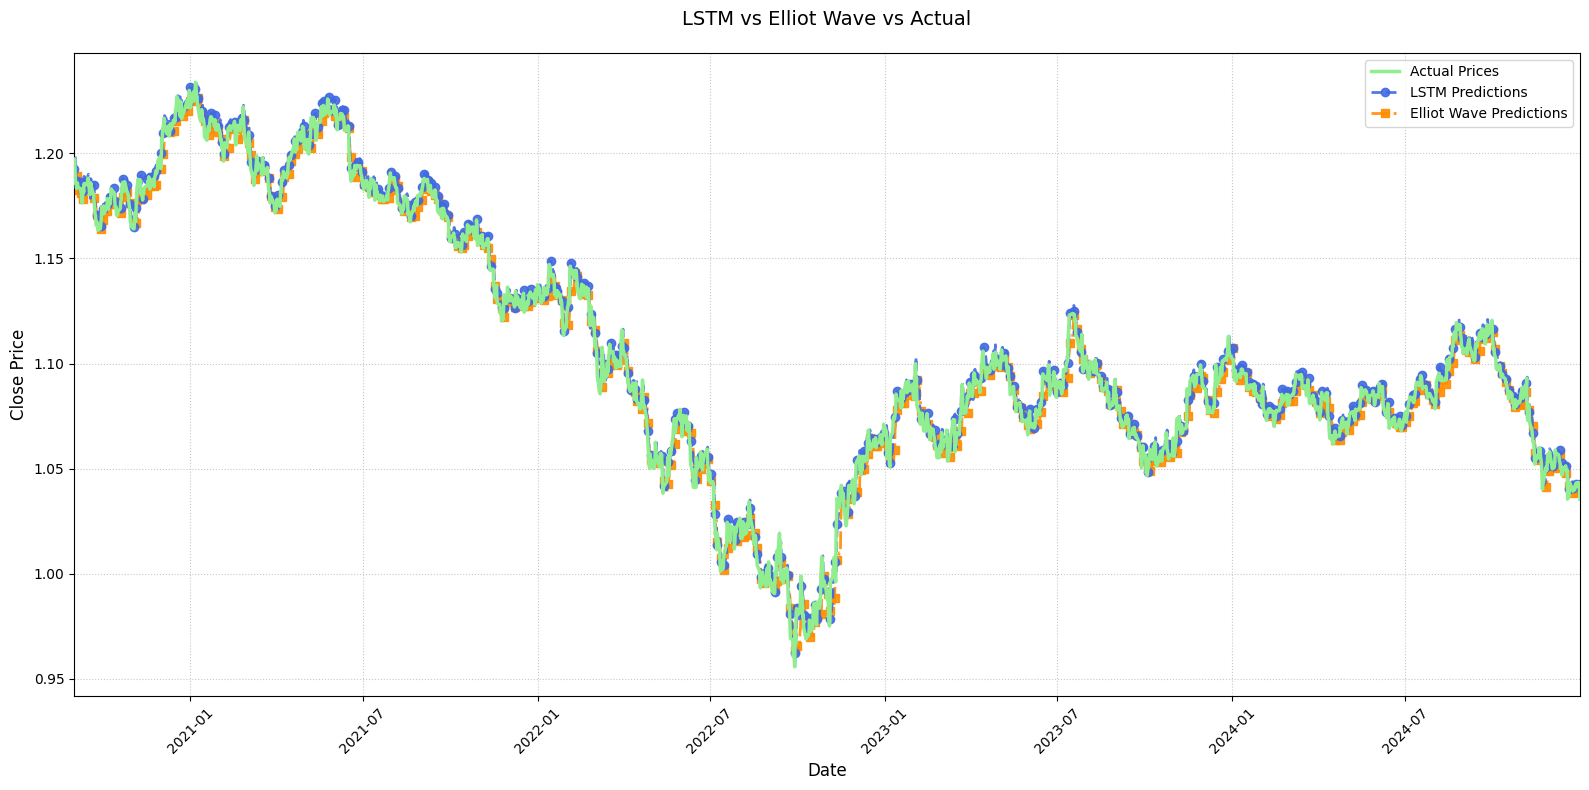

In [21]:
plt.figure(figsize=(16, 8))  # Slightly larger figure

# Plot Actual Prices (most prominent)
plt.plot(test_dates, test_actual,
         label='Actual Prices',
         linestyle='-',
         color='lightgreen',  # More professional color
         linewidth=2.5,
         zorder=3)  # Bring to front

# Plot LSTM Predictions
plt.plot(test_dates, test_pred_inv_lstm,
         label='LSTM Predictions',
         color='royalblue',  # Distinct from actuals
         linestyle='--',
         linewidth=2,
         marker='o',  # Add markers for visibility
         markevery=5,  # Show markers every 5 points
         markersize=6,
         alpha=0.9,
         zorder=2)

# Plot Elliot Wave Predictions
plt.plot(test_dates, test_pred_ew,
         label='Elliot Wave Predictions',
         color='darkorange',  # Better contrast than yellow
         linestyle='-.',
         linewidth=2,
         marker='s',  # Different marker shape
         markevery=5,
         markersize=6,
         alpha=0.9,
         zorder=1)

# Title and labels
plt.title('LSTM vs Elliot Wave vs Actual', fontsize=14, pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price', fontsize=12)


plt.legend()

# Grid and formatting
plt.grid(True, linestyle=':', alpha=0.7, zorder=0)
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to accommodate legend

# Optional: Highlight key areas
min_date, max_date = test_dates.iloc[0], test_dates.iloc[-1]
price_range = [min(test_actual.min(), test_pred_inv_lstm.min(), test_pred_ew.min()),
              max(test_actual.max(), test_pred_inv_lstm.max(), test_pred_ew.max())]
buffer = (price_range[1] - price_range[0]) * 0.05

plt.xlim(min_date, max_date)
plt.ylim(price_range[0] - buffer, price_range[1] + buffer)

# Optional: Add vertical spans for volatile periods
# plt.axvspan(start_date, end_date, alpha=0.1, color='gray')

plt.show()


Pearson Correlation between models: 0.9982


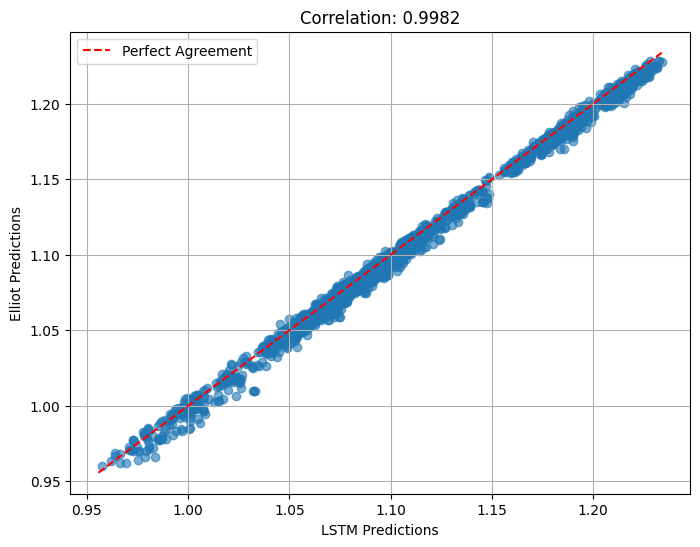

In [22]:
# 2. Correlation Analysis
from scipy.stats import pearsonr

corr, _ = pearsonr(test_pred_inv_lstm, test_pred_ew)
print(f"\nPearson Correlation between models: {corr:.4f}")

# Scatter plot of predictions
plt.figure(figsize=(8, 6))
plt.scatter(test_pred_inv_lstm, test_pred_ew, alpha=0.6)
plt.plot([min(test_actual), max(test_actual)],
        [min(test_actual), max(test_actual)],
        'r--', label='Perfect Agreement')
plt.xlabel('LSTM Predictions')
plt.ylabel('Elliot Predictions')
plt.title(f'Correlation: {corr:.4f}')
plt.legend()
plt.grid(True)
plt.show()

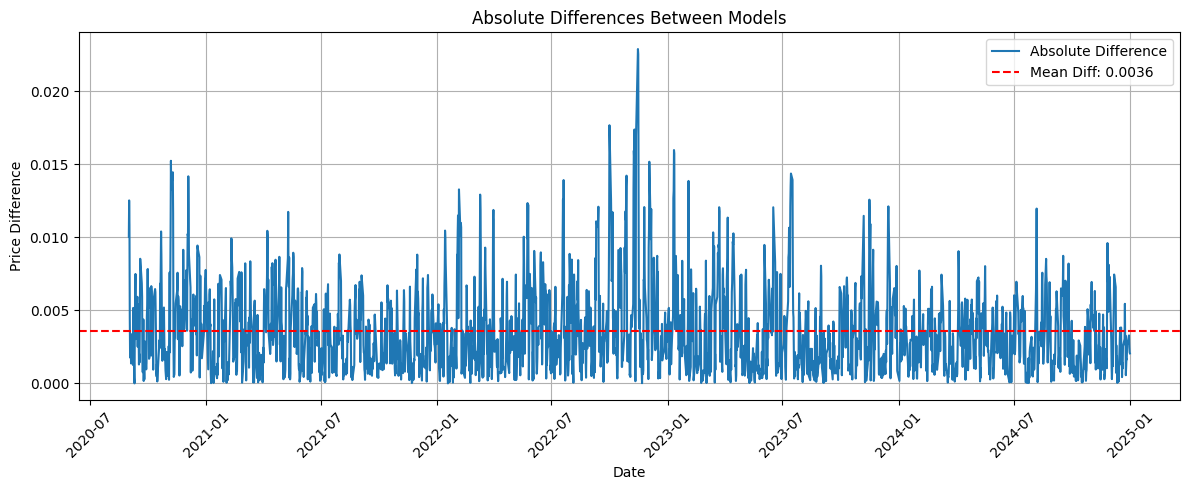

In [23]:
# 3. Absolute Differences Analysis
price_diffs = np.abs(test_pred_inv_lstm - test_pred_ew)
avg_diff = np.mean(price_diffs)
std_diff = np.std(price_diffs)

plt.figure(figsize=(12, 5))
plt.plot(test_dates, price_diffs, label='Absolute Difference')
plt.axhline(y=avg_diff, color='r', linestyle='--', label=f'Mean Diff: {avg_diff:.4f}')
plt.title('Absolute Differences Between Models')
plt.xlabel('Date')
plt.ylabel('Price Difference')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [25]:
# 5. Performance Metrics Comparison
metrics_comparison = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'MAPE', 'R²'],
    # Access metrics by key instead of index
    'LSTM Train': [train_metrics[0], train_metrics[1], train_metrics[2], train_metrics[3]],
    'LSTM Test': [test_metrics[0], test_metrics[1], test_metrics[2], test_metrics[3]],
    'Elliot Train': [train_metrics_ew['MAE'], train_metrics_ew['RMSE'],
                    train_metrics_ew['MAPE'], train_metrics_ew['R2']],
    'Elliot Test': [test_metrics_ew['MAE'], test_metrics_ew['RMSE'],
                   test_metrics_ew['MAPE'], test_metrics_ew['R2']]
})

print("\nPerformance Metrics Comparison:")
print(metrics_comparison.to_string(index=False))


Performance Metrics Comparison:
Metric  LSTM Train  LSTM Test  Elliot Train  Elliot Test
   MAE    0.004720   0.003270      0.006466     0.004261
  RMSE    0.006398   0.004290      0.008681     0.005667
  MAPE    0.372659   0.297867      0.510009     0.389032
    R²    0.997259   0.995051      0.994952     0.991363


In [26]:
# 6. Additional Comparative Analysis
# a. Directional Accuracy
def directional_accuracy(actual, predicted):
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)
    return np.mean((actual_diff > 0) == (pred_diff > 0)) * 100

print(f"\nLSTM Directional Accuracy: {directional_accuracy(test_actual, test_pred_inv_lstm):.2f}%")
print(f"Elliot Directional Accuracy: {directional_accuracy(test_actual, test_pred_ew):.2f}%")

# b. Volatility Comparison
volatility_actual = np.std(np.diff(test_actual)/test_actual[:-1])
volatility_lstm = np.std(np.diff(test_pred_inv_lstm)/test_pred_inv_lstm[:-1])
volatility_elliot = np.std(np.diff(test_pred_ew)/test_pred_ew[:-1])

print(f"\nVolatility Comparison:")
print(f"Actual: {volatility_actual:.4f}")
print(f"LSTM: {volatility_lstm:.4f}")
print(f"Elliot: {volatility_elliot:.4f}")


LSTM Directional Accuracy: 49.09%
Elliot Directional Accuracy: 49.36%

Volatility Comparison:
Actual: 0.0033
LSTM: 0.0028
Elliot: 0.0017
